<a href="https://colab.research.google.com/github/ginomempin/machine-learning-tutorials/blob/master/src/ConvolutionalNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OVERVIEW

This notebook demonstrates the creation, training, and testing of a **Convolutional Neural Network**.  
The network will classify handwritten numbers from the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

### Reference

[ginomempin / machine-learning-tutorials / docs / ConvolutionalNeuralNetworks.md](https://github.com/ginomempin/machine-learning-tutorials/blob/master/docs/ConvolutionalNeuralNetworks.md)

### Note

This notebook requires the use of GPU (or not if you want slow/long training times).  

When running in Google Colab:
1. Select "Runtime" from the menu
1. Select "GPU" as the hardware accelerator type.

In [0]:
!pip3 install torch torchvision

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn 
from torchvision import datasets    # Contains the MNIST image dataset
from torchvision import transforms  # Contains common image pre-processing functions

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setup the Training Set

## Define the Image Transformation

In [0]:
transform = transforms.Compose([
    # No effect on MNIST images, but useful for
    # passing in test images of random sizes.
    transforms.Resize((28, 28)),

    # Convert from Numpy array 0-255 to PyTorch Tensor 0-1
    transforms.ToTensor(),  

    # For each tensor, normalize the values of image size,
    # channel height and channel width. The 1st parameter
    # is the mean and the 2nd parameter is the standard 
    # deviation. Make sure to specify only 1 channel since
    # the MNIST dataset provides grayscale images.
    #
    # We choose 0.5 because we want to normalize the Tensor
    # values from [0, 1] to be [-1, 1].
    #   Ex. If value is 0 (minimum Tensor value)
    #           (0 - 0.5) / 0.5 = -1
    #   Ex. If value is 1 (maximum Tensor value)
    #           (1 - 0.5) / 0.5 = +1
    #
    # Ultimately, we want to normalize to reduce skewness
    # and distorted data values.    
    transforms.Normalize((0.5,), (0.5,))
])

## Define the Dataset

In [0]:
training_dataset = datasets.MNIST(
    root="./data",          # Where the MNIST dataset will be stored
    train=True,             # Create a Training Set
    download=True,          # Downloads from internet and put in `root` directory
    transform=transform     # Image manipulations that will be applied to the images 
)
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [0]:
# Provides a way to load the input data into the model in batches.
# Before we pass the entire data into the network every epoch.
 # With 60k data points, this would not be an efficient strategy.
training_loader = torch.utils.data.DataLoader(
    dataset=training_dataset,
    batch_size=100,
    shuffle=True            # Prevent getting stuck into local/false minimums
                            # Make sure that each epoch uses a different batch
)
training_loader

## Plot the Dataset

In [0]:
# To plot, we need to convert the Tensor back to Numpy array.
def img_convert(tensor: torch.Tensor):
    image = tensor.cpu().clone().detach().numpy()

    # Convert from 1x28x28 shape to 28x28x1
    # The MNIST dataset are in grayscale, hence only 1 channel.
    # Then each image is 28x28.
    # print(image.shape)
    image = image.transpose(1, 2, 0)

    # De-normalize (reverse the normalization process earlier)
    # Convert it from [-1, 1] back to the original [0, 1]
    image = image * np.array((0.5,)) + np.array((0.5,))
    image = image.clip(0, 1)

    # print(image.shape)
    return image

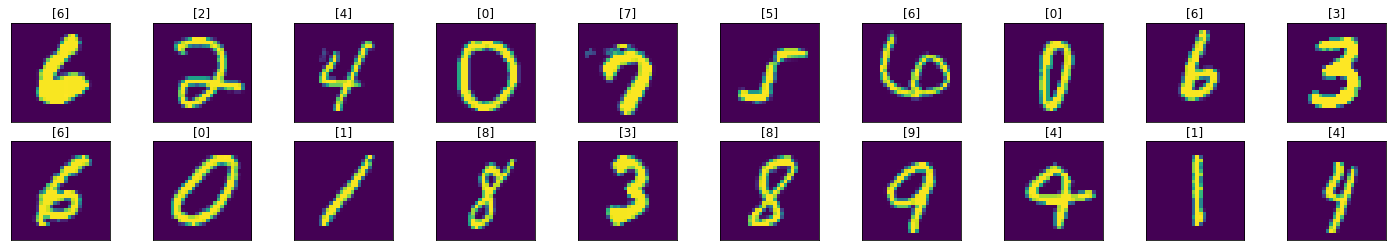

In [0]:
# Create an iterable object
# We can then use `next()` to iteratively get the next batch of data
training_dataset_iter = iter(training_loader)

images, labels = training_dataset_iter.next()
fig = plt.figure(
    figsize=(25, 4),
)

# Plot 20 MNIST images from the current batch
for idx in np.arange(20):
    # Make 2 rows of 10 columns
    # Note that idx is 0-based, but need to be 1-20
    axis = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])  

    # Show the i-th image (using the Tensor -> Numpy conversion)
    img = img_convert(images[idx])
    img = np.squeeze(img)
    plt.imshow(img)

    # Show the labels for each i-th image
    axis.set_title( [labels[idx].item()] )

# Setup the Validation Set

In [0]:
validation_dataset = datasets.MNIST(
    root="./data",          # Where the MNIST dataset will be stored
    train=False,            # Create a Validation Set
    download=True,          # Downloads from internet and put in `root` directory
    transform=transform     # Image manipulations that will be applied to the images 
)
validation_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [0]:
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset,
    batch_size=100,
    shuffle=False
)
validation_loader

# Setup the Network

We will use the **LeNet** model as the reference for our model.

It consists of 2 convolutional-pooling layers followed by 2 FCNs.  
Using a 5x5 kernel effectively reduces the feature matrix size by 4 pixels.  
And using a max pooling function further cuts the size in half.

See [CNN-2-Architecture-24](https://github.com/ginomempin/machine-learning-tutorials/blob/master/docs/ConvolutionalNeuralNetworks.md#-and-repeat) for the dimension changes.

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            1,      # Input is grayscale image
            20,     # Number of features to extract
            5,      # Kernel size
            1       # Stride
        )
        self.conv2 = nn.Conv2d(
            20,     # Input is the features from previous conv layer
            50,     # Number of features to extract
            5,      # Kernel size
            1       # Stride
        )
        self.fc1 = nn.Linear(
            4*4*50, # Each input feature will be 4x4
                    #   28x28 -conv1-> 24x24 -pool1-> 12x12 -conv2-> 8x8 -pool2-> 4x4
                    # Then there are 50 features from conv2
            500     # Hidden layer
        )
        self.dropout1 = nn.Dropout(     
            0.5     # Add a dropout layer to fix the overfitting problem.
                    # Try removing this layer, and the performance after
                    # training shows that the training accuracy is higher
                    # than the validation accuracy, indicating memorization
                    # of the training data, or overfitting.
        )
        self.fc2 = nn.Linear(
            500,    # Hidden layer
            10      # 1 class for each possible digit
        ) 
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 kernel
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 kernel
        x = x.view(-1, 4*4*50)     # 1x(4x4x50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)            # Do not apply an activation function for non-binary classification
        return x

In [0]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

# Setup the Loss Function and Optimizer

In [0]:
# Use Cross Entropy Loss for multi-class datasets (instead of BCE for binary data)
criterion = nn.CrossEntropyLoss()  

# Use Gradient Descent to optimize the model.
# Specifically, the Adam optimizer (Adaptive Method Algorithms).
# The Adam optimizer is a combination of 2 extensions of SGD (Stochastic Gradient Descent):
#   Adagrad
#   RMSprop
# What distinguishes it from the SGD is that we had to be careful in choosing the proper
# the learning rate. Too small leads to very slow convergence towards minimum error/loss, 
# while too large can hinder the convergence. When using Adam optimization, it computes 
# the adaptive learning rates for EACH parameter. In practice, Adam is recommended as the
# default optimization algorithm.
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001    # Originally, it was set to 0.01, but the plot of the loss after
                 # training was observed to be fluctuating, meaning the updates to 
                 # the model params were too drastic. When this happens, lower the
                 # learning rate.
)

# Training + Validation

In [0]:
epochs = 10

training_loss_history = []
training_acc_history = []

validation_loss_history = []
validation_acc_history = []

for e in range(epochs):

    # For each epoch, iterate over all the batches to be provided
    # by the training_loader, and keep track of the *total* loss
    # for all batches.
    training_running_loss = 0.0
    training_running_acc = 0.0
    validation_running_loss = 0.0
    validation_running_acc = 0.0

    print("Epoch: {}".format(e + 1))

    # Training Loop
    for images, labels in training_loader:
        inputs = images.to(device)
        labels = labels.to(device)

        # Feedforward through the model
        outputs = model.forward(inputs)

        # Get the current loss
        loss = criterion(outputs, labels)
        training_running_loss += loss.item()

        # Backpropagate the loss to update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get the current maximum scored class for each output
        # Returns a tuple
        #   0: The image scores for each of the classes
        #   1: The index of the top score (i.e. which class does each image belong to?)
        _, preds = torch.max(outputs, 1)
        training_running_acc += torch.sum(preds == labels.data)    
            # Example:
            #   If preds  = [2 3 4 5 6]
            #      labels = [2 5 4 5 6]
            #   So only the 2nd prediction is incorrect.
            #   So preds == labels will be [1 0 1 1 1].
    else:  
        epoch_training_loss = training_running_loss / len(training_loader)
        epoch_training_acc  = training_running_acc.float() / len(training_loader)
        # Note that this divide by batch size only works because batch_size = 100.
        # So, dividing the loss/acc by 100 automatically gives a % value.
        # If the batch size is != 100, divide instead by the dataset size
        #   epoch_training_loss = training_running_loss / len(training_loader.dataset)
        #   epoch_training_acc  = training_running_acc.float() / len(training_loader.dataset)        

        training_loss_history.append(epoch_training_loss)
        training_acc_history.append(epoch_training_acc)

        print("Training Loss:{:.4f}, Acc:{:.4f}".format(epoch_training_loss, epoch_training_acc))

    # Validation Loop
    with torch.no_grad():
        for images, labels in validation_loader:
            inputs = images.to(device)
            labels = labels.to(device)

            outputs = model.forward(inputs) 
            
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            validation_running_acc += torch.sum(preds == labels.data)
        else:  
            epoch_validation_loss = validation_running_loss / len(validation_loader)
            epoch_validation_acc  = validation_running_acc.float() / len(validation_loader)
            # Note that this divide by batch size only works because batch_size = 100.
            # So, dividing the loss/acc by 100 automatically gives a % value.  
            # If the batch size is != 100, divide instead by the dataset size
            #   epoch_training_loss = validation_running_loss / len(validation_loader.dataset)
            #   epoch_training_acc  = validation_running_acc.float() / len(validation_loader.dataset)                      

            validation_loss_history.append(epoch_validation_loss)
            validation_acc_history.append(epoch_validation_acc)

            print("Validation Loss:{:.4f}, Acc:{:.4f}".format(epoch_validation_loss, epoch_validation_acc))            

Epoch: 1
Training Loss:0.5600, Acc:84.5367
Validation Loss:0.1850, Acc:94.5300
Epoch: 2
Training Loss:0.1528, Acc:95.5350
Validation Loss:0.1052, Acc:96.8000
Epoch: 3
Training Loss:0.1031, Acc:96.8967
Validation Loss:0.0792, Acc:97.6500
Epoch: 4
Training Loss:0.0808, Acc:97.5550
Validation Loss:0.0646, Acc:98.0300
Epoch: 5
Training Loss:0.0679, Acc:97.9600
Validation Loss:0.0574, Acc:98.2300
Epoch: 6
Training Loss:0.0583, Acc:98.2433
Validation Loss:0.0497, Acc:98.3300
Epoch: 7
Training Loss:0.0510, Acc:98.4250
Validation Loss:0.0445, Acc:98.5600
Epoch: 8
Training Loss:0.0459, Acc:98.6167
Validation Loss:0.0424, Acc:98.5700
Epoch: 9
Training Loss:0.0414, Acc:98.7100
Validation Loss:0.0385, Acc:98.6800
Epoch: 10
Training Loss:0.0373, Acc:98.8333
Validation Loss:0.0356, Acc:98.8600


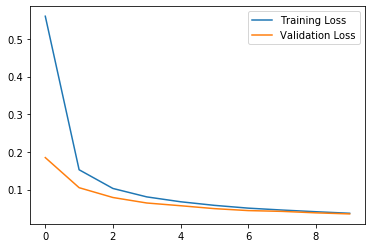

In [0]:
plt.plot(training_loss_history, label="Training Loss")
plt.plot(validation_loss_history, label="Validation Loss")
plt.legend()

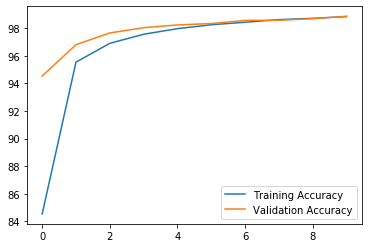

In [0]:
plt.plot(training_acc_history, label="Training Accuracy")
plt.plot(validation_acc_history, label="Validation Accuracy")
plt.legend()

# Testing

Test Links:

* https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg

## Get a Test Image

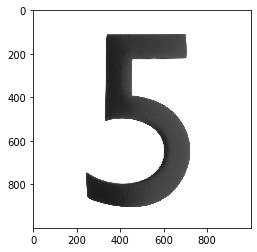

In [0]:
from PIL import Image, ImageOps
import requests

url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
resp = requests.get(url, stream=True)

img = Image.open(resp.raw)
plt.imshow(img)

## Do image preprocessing

The test image must match the image format on which our model was trained on.  
* White text on Black background
* 28x28
* 1-channel grayscale (not RGB)

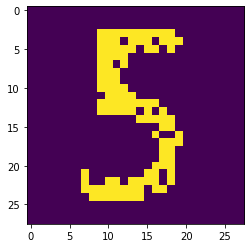

In [0]:
img = ImageOps.invert(img.convert('RGB'))   # black-on-white to white-on-black
img = img.convert('1')                      # grayscale
img = transform(img)                        # apply model's expected image format
plt.imshow(np.squeeze(img_convert(img)))

## Feed to Model

In [0]:
# Make sure to use different variable to distinguish result of passing to GPU
# image and the previous Numpy `img`.
images = img.to(device)     
print(images[0].size())

torch.Size([28, 28])


In [0]:
# Need 4D input to the network
# Convert 28x28 to 1x1x28x28
image = images[0].unsqueeze(0).unsqueeze(0)
print(image.size())

torch.Size([1, 1, 28, 28])


In [0]:
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5
